In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

# Llevamos el repositorio a nuestro drive

In [ ]:
# Esto solo debemos ejecutarlo una vez. Si lo ejecutamos mas de una vez va a fallar (pero no pasa nada!)
!mkdir /content/gdrive/My\ Drive/ml-practico/code
# Acá podes usar tu propio repo si queres hacer modificaciones (highly recommended)
!git clone https://github.com/elsonidoq/machine_learning_practico /content/gdrive/My\ Drive/ml-practico/code

In [ ]:
# Si hay cambios en el repositorio, con esta linea actualizas tu drive
!cd /content/gdrive/My\ Drive/ml-practico/code; git pull

In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/ml-practico/code')

In [4]:
import sys
sys.path.append('/Users/przivic/prog/machine_learning_practico')

# Loading the data

In [ ]:
SAMPLE = False

In [5]:
from lib import transformers, data

In [6]:
from random import sample
from pathlib import Path

movies = data.load_data(Path('../../data/'))

if SAMPLE:
    # TODO: check wither 50k is ok
    movies = movies.sample(50000)

Loading title basics...


/Users/przivic/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading title ratings...
Loading movie directors...
Merging everything...


# Model helpers

In [7]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.feature_extraction import DictVectorizer

def get_features_pipe(
        use_years: bool, use_genre: bool, 
        use_director: bool, director_kws: dict=None, post_processing=None):
    """
    Construye el pipeline de features de forma parametrizada
    """
    # director_kws solo tiene sentido cuando use_director=True. 
    # Esto nos va a traer dolores de cabeza a la hora de explorar el espacio de hyper parametros
    # TODO: esto debería permitir cachear los datasets transformados
    
    steps = []
    if use_years:
        steps.append(make_pipeline(transformers.YearsAgo(), DictVectorizer(sparse=False)))
    
    if use_genre:
        steps.append(make_pipeline(transformers.GenreDummies(), DictVectorizer(sparse=False)))
        
    if use_director:
        director_kws = director_kws or {}
        # cuando hacemos **director_kws usamos ese diccionario para pasar parametros
        steps.append(make_pipeline(transformers.DirectorFeatures(**director_kws), DictVectorizer(sparse=False)))
    
    res = make_union(*steps)
    if post_processing:
        res = make_pipeline(res, post_processing)
    return res

def get_model_pipe(features_pipe, estimator):
    return make_pipeline(features_pipe, estimator)

# Modelado sencillo

Para ejemplificar el model selection. La proxima clase iteramos sobre esto

1. Modelamos el problema como clasificacion P(rating > 7.5)
2. Evaluamos con f_beta score, con beta = 0.5

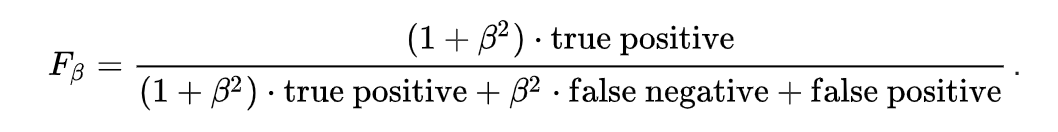

In [8]:
train_df = movies[movies.startYear <= 2015]
dev_df = movies[(movies.startYear > 2015) & (movies.startYear <= 2017)]
test_df = movies[movies.startYear > 2017]

X_train = train_df.to_dict(orient='records')
X_dev = dev_df.to_dict(orient='records')
X_test = test_df.to_dict(orient='records')

len(train_df), len(dev_df), len(test_df), len(test_df) / len(train_df), len(dev_df) / len(train_df)

(251521, 20324, 21170, 0.08416792236035957, 0.08080438611487709)

In [9]:
y_train = (train_df.averageRating > 7.5).values
y_dev = (dev_df.averageRating > 7.5).values
y_test = (test_df.averageRating > 7.5).values

y_train.sum() / len(y_train), y_dev.sum() / len(y_dev), y_test.sum() / len(y_test)

(0.14882256352352288, 0.18219838614445974, 0.17198866320264525)

## Ejemplo de uso

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

model = get_model_pipe(
    features_pipe=get_features_pipe(
        use_years=False, use_director=True, use_genre=True, post_processing=StandardScaler()
    ),
    estimator=LogisticRegression()   
)

model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('featureunion',
                                  FeatureUnion(transformer_list=[('pipeline-1',
                                                                  Pipeline(steps=[('genredummies',
                                                                                   GenreDummies()),
                                                                                  ('dictvectorizer',
                                                                                   DictVectorizer(sparse=False))])),
                                                                 ('pipeline-2',
                                                                  Pipeline(steps=[('directorfeatures',
                                                                                   DirectorFeatures()),
                                                                                  ('dictvectorizer',
                                    

In [10]:
from sklearn.metrics import fbeta_score, roc_auc_score

def get_metrics(model, X, y, threshold=0.5):
    scores = model.predict_proba(X)[:, 1]
    return {
        'f_0.5': fbeta_score(y, scores > threshold, beta=0.5),
        'roc_auc': roc_auc_score(y, scores)
    }

In [20]:
model.fit(X_train, y_train);

In [21]:
y_pred_train = model.predict_proba(X_train)[: , 1]
y_pred_train[:10]

array([0.08653449, 0.39716409, 0.01291727, 0.09266566, 0.08935667,
       0.00626794, 0.03328152, 0.05521897, 0.07921332, 0.16316353])

In [22]:
# Para jugar: como cambia la metrica cuando tocamos el threshold y beta?
# Se mueve como esperamos que se mueva?

fbeta_score(y_train, y_pred_train > 0.5, beta=0.5)

0.4916281988986071

In [23]:
get_metrics(model, X_train, y_train)

{'f_0.5': 0.4916281988986071, 'roc_auc': 0.8325748470236662}

In [24]:
get_metrics(model, X_dev, y_dev)

{'f_0.5': 0.22235311441613903, 'roc_auc': 0.7318091294695129}

Parece haber un roc auc relativamente bueno, sin embargo el f_0.5 da super bajo.

### Para pensar 🤔
Cómo podríamos optimizar el f_0.5 cambiando el threshold?

# Grid search

In [11]:
from time import time
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def experiment_lr(model_params, feature_params, X_train, y_train, X_dev, y_dev):
    # Resolvemos el tema del director
    feature_params['use_director'] = feature_params['director_kws'] is not None
    
    model = get_model_pipe(
        features_pipe=get_features_pipe(**feature_params),
        estimator=LogisticRegression(**model_params)
    )
    
    t0 = time()
    model.fit(X_train, y_train)
    elapsed = time() - t0
    
    return {
        'model': model,
        'train_metrics': get_metrics(model, X_train, y_train),
        'dev_metrics': get_metrics(model, X_dev, y_dev),
        'params': {
            'model': model_params, 'feature': feature_params
        }
    }

In [14]:
from sklearn.model_selection import ParameterGrid

lr_grid = ParameterGrid(
    {
        'penalty': ['l1', 'l2'],
#         'tol': [1e-4, 1e-5, 1e-3],
        'C': [10.0, 1.0, 0.1],
        'class_weight': ['balanced', None],
        'solver': ['saga'],
    }
)

feature_grid = ParameterGrid(
    {
        'use_years': [True], 
        'use_genre': [True],  
        # Tenemos 2 hyper parametros interdependientes, solo seteamos director_kws
        'director_kws': [None, dict(min_cnt_movies=0), dict(min_cnt_movies=3)],
        'post_processing': [StandardScaler()] # siempre hacemos esto porque es regresion logistica
    }
)

In [15]:
from tqdm.notebook import tqdm

def run_lr_experiments(): 
    # No toma parametros porque usa las variables globales que definimos durante el notebook
    
    results = []
    for model_params in tqdm(list(lr_grid)):
        for feature_params in feature_grid:
            empty_features = (
                not feature_params['use_years'] and 
                not feature_params['use_genre'] and 
                feature_params['director_kws'] is None
            )
            if empty_features: continue  # esta combinacion no tiene sentido probarla porque no usa ningun feature

            results.append(experiment_lr(model_params, feature_params, X_train, y_train, X_test, y_test))
    
    return results

In [16]:
experiment_outputs = run_lr_experiments()

In [28]:
import pandas as pd

experiment_outputs_flat = []
for e_nested in experiment_outputs:
    e_flat = {
        'train_auc': e_nested['train_metrics']['roc_auc'],
        'dev_auc': e_nested['dev_metrics']['roc_auc'],
    }
    e_flat.update(e_nested['params']['model'])
    e_flat.update(e_nested['params']['feature'])
    experiment_outputs_flat.append(e_flat)
    
experiments_df = pd.DataFrame(experiment_outputs_flat).drop('post_processing', axis=1)

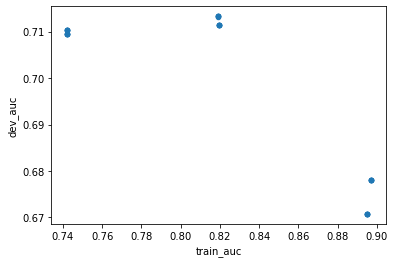

In [31]:
experiments_df.plot.scatter('train_auc', 'dev_auc')

In [32]:
experiments_df.sort_values('train_auc', ascending=False)

,train_auc,dev_auc,C,class_weight,penalty,solver,director_kws,use_genre,use_years,use_director
28,0.897083,0.678134,0.1,balanced,l2,saga,{'min_cnt_movies': 0},True,True,True
16,0.897082,0.678119,1.0,balanced,l2,saga,{'min_cnt_movies': 0},True,True,True
4,0.897082,0.678117,10.0,balanced,l2,saga,{'min_cnt_movies': 0},True,True,True
1,0.897081,0.678117,10.0,balanced,l1,saga,{'min_cnt_movies': 0},True,True,True
13,0.897081,0.678109,1.0,balanced,l1,saga,{'min_cnt_movies': 0},True,True,True
25,0.897078,0.678065,0.1,balanced,l1,saga,{'min_cnt_movies': 0},True,True,True
34,0.894868,0.670786,0.1,None,l2,saga,{'min_cnt_movies': 0},True,True,True
22,0.894850,0.670776,1.0,None,l2,saga,{'min_cnt_movies': 0},True,True,True
10,0.894848,0.670783,10.0,None,l2,saga,{'min_cnt_movies': 0},True,True,True
7,0.894848,0.670780,10.0,None,l1,saga,{'min_cnt_movies': 0},True,True,True


In [33]:
best = max(experiment_outputs, key=lambda x: x['dev_metrics']['roc_auc'])

In [34]:
best

{'model': Pipeline(memory=None,
          steps=[('pipeline',
                  Pipeline(memory=None,
                           steps=[('featureunion',
                                   FeatureUnion(n_jobs=None,
                                                transformer_list=[('pipeline-1',
                                                                   Pipeline(memory=None,
                                                                            steps=[('yearsago',
                                                                                    YearsAgo()),
                                                                                   ('dictvectorizer',
                                                                                    DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                                                   separator='=',
                                                                             

### Para pensar 🤔

Usando este código de base, como implementarías random search?

# Hyperopt: Sequential Model Based Optimization

https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

In [ ]:
!pip install hyperopt

In [49]:
import numpy as np
from hyperopt import hp

lr_space = {
    'model_params': {
            'penalty': hp.choice('penalty', ['l1', 'l2']),
            'C': hp.loguniform('C', np.log(0.001), np.log(100)),
            'class_weight': hp.choice('class_weight', ['balanced', None]),
            'solver': 'saga',
        },
    
    'feature_params': {
        'use_years': hp.choice('use_years', [True, False]),
        'use_genre': hp.choice('use_genre', [True, False]), 
        # Tenemos 2 hyper parametros interdependientes, solo seteamos director_kws
        'director_kws': hp.choice('director_kws', 
                    [None, dict(min_cnt_movies=0), 
                     dict(min_cnt_movies=1), dict(min_cnt_movies=2), dict(min_cnt_movies=3),
                     dict(min_cnt_movies=6), dict(min_cnt_movies=8), dict(min_cnt_movies=10)
                    ]
        ),
        'post_processing': StandardScaler() # siempre hacemos esto porque es regresion logistica
    }
}

In [50]:
import pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, STATUS_FAIL

def objective(x):
    feature_params = x['feature_params']
    model_params = x['model_params']
    
    empty_features = (
        not feature_params['use_years'] and 
        not feature_params['use_genre'] and 
        feature_params['director_kws'] is None
    )
    if empty_features:   
        # esta combinacion no tiene sentido probarla porque no usa ningun feature
        # misma cosa que en el grid search
        return {'loss': 1000, 'status': STATUS_FAIL}

    exp_output = experiment_lr(model_params, feature_params, X_train, y_train, X_test, y_test)
    exp_output['loss'] = -exp_output['dev_metrics']['roc_auc']
    exp_output['status'] = STATUS_OK
    return exp_output

trials = Trials()
fmin(
    objective,
    space=lr_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
);

100%|██████████| 100/100 [17:44<00:00, 10.65s/trial, best loss: -0.7141907217934876]


In [54]:
trials.best_trial

{'state': 2,
 'tid': 62,
 'spec': None,
 'result': {'model': Pipeline(memory=None,
           steps=[('pipeline',
                   Pipeline(memory=None,
                            steps=[('featureunion',
                                    FeatureUnion(n_jobs=None,
                                                 transformer_list=[('pipeline-1',
                                                                    Pipeline(memory=None,
                                                                             steps=[('yearsago',
                                                                                     YearsAgo()),
                                                                                    ('dictvectorizer',
                                                                                     DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                                                    separator='=',
               

## Para pensar 🤔

* Cómo se adaptaría todo esto para usar GradientBoostingClassifier, o lightgbm?
* Qué pasa promediáramos la mejor regresion logística con el mejor arbol? Mejoraría?
* Valdría la pena esa ganancia en performance para el problema que queremos resolver? Al principio del proyecto? 1 año despues de que arranco? Nunca?

* Si hiciste algun feature transformer extra? Cómo evaluarías si ese transformer mejora?

# Auto sklearn

In [ ]:
# para instalar en colab
!apt-get install swig -y
!pip install Cython numpy

!pip3 install auto-sklearn

In [15]:
import autosklearn.classification
from autosklearn.metrics import roc_auc

model = get_model_pipe(
    features_pipe=get_features_pipe(
        use_years=False, use_director=True, use_genre=True, post_processing=StandardScaler()
    ),
    estimator=autosklearn.classification.AutoSklearnClassifier(metric=roc_auc)
)


model.fit(X_train, y_train)

/Users/przivic/anaconda3/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('featureunion',
                                  FeatureUnion(n_jobs=None,
                                               transformer_list=[('pipeline-1',
                                                                  Pipeline(memory=None,
                                                                           steps=[('genredummies',
                                                                                   GenreDummies()),
                                                                                  ('dictvectorizer',
                                                                                   DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                                                  separator='=',
                                                                                          

In [17]:
get_metrics(model, X_train, y_train)

{'f_0.5': 0.508147053785543, 'roc_auc': 0.900888584449598}

In [18]:
get_metrics(model, X_dev, y_dev)

{'f_0.5': 0.40168726152553647, 'roc_auc': 0.7491232999753378}

## Ojo! 👀

AutoSklearnClassifier usa modelos no lineales y lo de arriba esta todo hecho con una regresion logística!